In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

## **Data Preprocessing**

After importing all the necessary packages my first task is to preprocess the data to get a well organized dataframe that I can properly work with. I begin the preprocessing by loading the dataframe and reformatting the names of the columns. Next, I get dummy variables for the 'status' column as this is a non-numerical column that cannot be used for regression unless it is changed to a numerical column. I also decide to drop one of the dummy columns as the second dummy column is redundant. There is also a typo in the column names as the 'thinness_1_19_years' column actually refers to the prevalence of thinness for people with age 10 to 19. Lastly, I want to ensure that all the countries have exactly 16 years of data so that there is balanced data for each country. However, it is worth noting that this dataset is indeed imbalanced in the sense that there is significantly more data for developing countries compared to developed countries.

In [3]:
def preprocess():
    path_to_file = "data/new_life_expectancy.csv"
    life_expectancy_df = pd.read_csv(path_to_file)
    
    life_expectancy_df.columns = life_expectancy_df.columns.str.strip().str.replace(pat="  ", repl=" ").str.replace(pat="[' '-/]", repl="_", regex=True).str.lower()
    life_expectancy_df = pd.get_dummies(data=life_expectancy_df, drop_first=True, columns=['status'], dtype=int)
    life_expectancy_df.columns = life_expectancy_df.columns.str.lower()
    life_expectancy_df = life_expectancy_df.rename(columns={'percentage_expenditure': 'per_expend',
                                                            'total_expenditure': 'total_expend',
                                                            'income_composition_of_resources': 'icr', 
                                                            'thinness_5_9_years': 'thin_5-9_years', 
                                                            'thinness_1_19_years': 'thin_10-19_years'})
    
    life_expectancy_df = life_expectancy_df.groupby('country').filter(lambda x: x.shape[0] == 16)
    life_expectancy_df = life_expectancy_df.sort_values(by=['country', 'year'], ascending=[True, False])

    return life_expectancy_df

life_expectancy_df = preprocess()

life_expectancy_df

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,per_expend,hepatitis_b,measles,bmi,...,total_expend,diphtheria,hiv_aids,gdp,population,thin_10-19_years,thin_5-9_years,icr,schooling,status_developing
0,Afghanistan,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,Afghanistan,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,8.18,62.0,0.1,612.696514,NaN,17.5,17.5,0.476,10.0,1
2,Afghanistan,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1
3,Afghanistan,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,8.52,67.0,0.1,669.959000,NaN,17.9,18.0,0.463,9.8,1
4,Afghanistan,2011,59.2,275.0,71,0.01,NaN,68.0,3013,17.2,...,7.87,68.0,0.1,NaN,NaN,18.2,18.2,0.454,9.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,Zimbabwe,2004,44.3,723.0,27,4.36,NaN,68.0,31,27.1,...,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,1
2924,Zimbabwe,2003,44.5,715.0,26,4.06,NaN,7.0,998,26.7,...,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,1
2925,Zimbabwe,2002,44.8,NaN,25,4.43,NaN,73.0,304,26.3,...,6.53,71.0,39.8,NaN,NaN,1.2,1.3,0.427,10.0,1
2926,Zimbabwe,2001,45.3,686.0,25,1.72,NaN,76.0,529,25.9,...,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,1


## **Filling in Missing Values**

We can see immediately by doing a simple query that there is a significant amount of missing data in the dataframe that must be adressed before any regression models can be implemented. To deal with these missing values I created the 'fill_missing_values' function that first splits the data into the training and testing datasets. The reason that I decided to split the data this early is because I want to eventually use a KNN imputer that I intend to fit to the training data and transform the testing data with. If I do not split the data before filling in missing values with a KNN imputer then I run the risk of causing data leaks between the training and testing data by possibly inferring missing values in the training dataset based on neighbors that would be in the testing data. However, before I implement this KNN algorithm I decided to use forward and backward filling to deal with as much missing data as possible before applying the KNN. However, I also noticed that there were many zero values in the dataset in columns where a zero value is suspicious. For instance, it does not make much sense for a country to have a zero value for 'infant_deaths', so for columns such as these I also decided to replace the zero values with null values. However, after applying the filling methods there will still be missing values for countries where there is not much data available to fill, which is where the KNN imputer comes in. I created the 'knn_processing' function to implement the KNN algorithm. I first transformed the train and test data based on a scaler that I fit to the train data. Then I fit the KNN imputer using the transformed training data and then applied the imputer to the training and testing data to fill in all of the remaining missing values. After all of this the function will return the training and testing data that no longer has any missing values. I created the 'missing_df' to verify that the function was performing as intended and as we can see there are indeed no more missing values. 

In [3]:
def fill_missing_values(X,y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=145)
    
    def forward_back_fill(df):
        
        countries = df.country
    
        features = ['infant_deaths', 'per_expend', 'measles', 'under_five_deaths', 'icr']
        df[features] = df[features].replace(to_replace=0, value=np.nan)
    
        df = df.groupby(['country']).transform(lambda x: x.fillna(method='ffill'))
        df['country'] = countries
    
        df = df.groupby(['country']).transform(lambda x: x.fillna(method='bfill'))# Use the next non-value to back-fill missing values.
        df['country'] = countries
        
        return df
        
    X_train_filled = forward_back_fill(X_train)
    X_test_filled = forward_back_fill(X_test)
    
    def knn_processing(X_train_filled, X_test_filled):
        
        X_train_filled_ = X_train_filled.drop(columns=['country'])
        X_test_filled_ = X_test_filled.drop(columns=['country'])
    
        scaler = StandardScaler()
        scaler.fit(X_train_filled_)
        X_train_rescaled = pd.DataFrame(scaler.transform(X_train_filled_))
        X_test_rescaled = pd.DataFrame(scaler.transform(X_test_filled_))
    
        # Let's use KNN to infer missing values (Note: might need to check the distribution of the data though: outliers, etc)
        knn_imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
        knn_imputer.fit(X_train_rescaled)
        
        X_train_filled[X_train_filled_.columns.values] = scaler.inverse_transform(knn_imputer.transform(X_train_rescaled))
        X_test_filled[X_test_filled_.columns.values] = scaler.inverse_transform(knn_imputer.transform(X_test_rescaled))
        
        return X_train_filled, X_test_filled
        
    X_train, X_test = knn_processing(X_train_filled, X_test_filled)
    
    return X_train, X_test, y_train, y_test

In [4]:
X = life_expectancy_df.loc[:, life_expectancy_df.columns != 'life_expectancy']
y = life_expectancy_df.loc[:, ['life_expectancy']]
X_train, X_test, y_train, y_test = fill_missing_values(X,y)

In [5]:
missing_df = pd.DataFrame(index = X_train.isna().sum().index, data={'X_train:':np.array(X_train.isna().sum()) , 'X_test':np.array(X_test.isna().sum())})
missing_df

,X_train:,X_test
year,0,0
adult_mortality,0,0
infant_deaths,0,0
alcohol,0,0
per_expend,0,0
hepatitis_b,0,0
measles,0,0
bmi,0,0
under_five_deaths,0,0
polio,0,0


## **Feature Engineering**

My first step in deciding which features would be the best regressors for the linear model was to visualize the distributions of all the features in the training data and see which features are approximately normally distributed. So, I created the 'display_feature distributions' function to get a quick visualization of the densities of all possible regressors which are represented by the green curves. As we can see there are many features such as 'total_expend' and 'schooling' that are suprisingly close to the ideal normal distribution represented by the purple curve. However, there are also features such as 'per_expend' and 'gdp' that appear to have skewed distributions which is not ideal when looking for the best regressors to train our model. So, similar to our discussions in lecture I created a second plot of the feature densities after applying a logarithmic transormation to hopefully deal with the skewness of certain features and perhaps engineer better regressors for our model. Comparing the first and second plots we can see that there are indeed certain features that greatly benefit from this log transformation, some examples include 'measles' and 'population'. Next, after doing this analysis I created the 'log_transform' function which takes in all the features that benefit from this transormation and performs the log operation. After performing the log transormation on these features we can expect improvement in the overall densities of our features. So, now that I know which features have desirable density distributions I wanted to see there variance and how well they are correlated with the response variable 'life_expectancy'. So, I create the 'agg_df' and as we can see 'adult_mortality' is not only highly correlated with 'life_expectancy' but it also is fairly normally distributed. Thus, we can see that this will likely be our top regressor when deciding which features are the best to fit our model. Furthermore, features such as 'icr' and 'schooling' are also features that are highly correlated with the response that have approximately normal densities meaning that these will likely be some other good regressors for our model. 

In [6]:
def display_feature_distributions(df):

    fig, ax = plt.subplots(4, 5)
    plt.rcParams["figure.figsize"] = [20, 10]
    plt.rcParams["figure.autolayout"] = True
    
    from itertools import product
    lst = [np.arange(0, 4), np.arange(0, 5)]
    couples = product(*lst) 
    
    for i, j in couples:
        feature = df.columns[5 * i + j]
        values = df[feature]
        ave = values.mean()
        sd = values.std()
        sns.kdeplot(x=values, fill=True, alpha=0.3, color='darkgreen', ax=ax[i, j]);
        sns.kdeplot(x=np.random.normal(loc=ave, scale=sd, size=100000), fill=True, alpha=0.2, color='purple', ax=ax[i, j]);

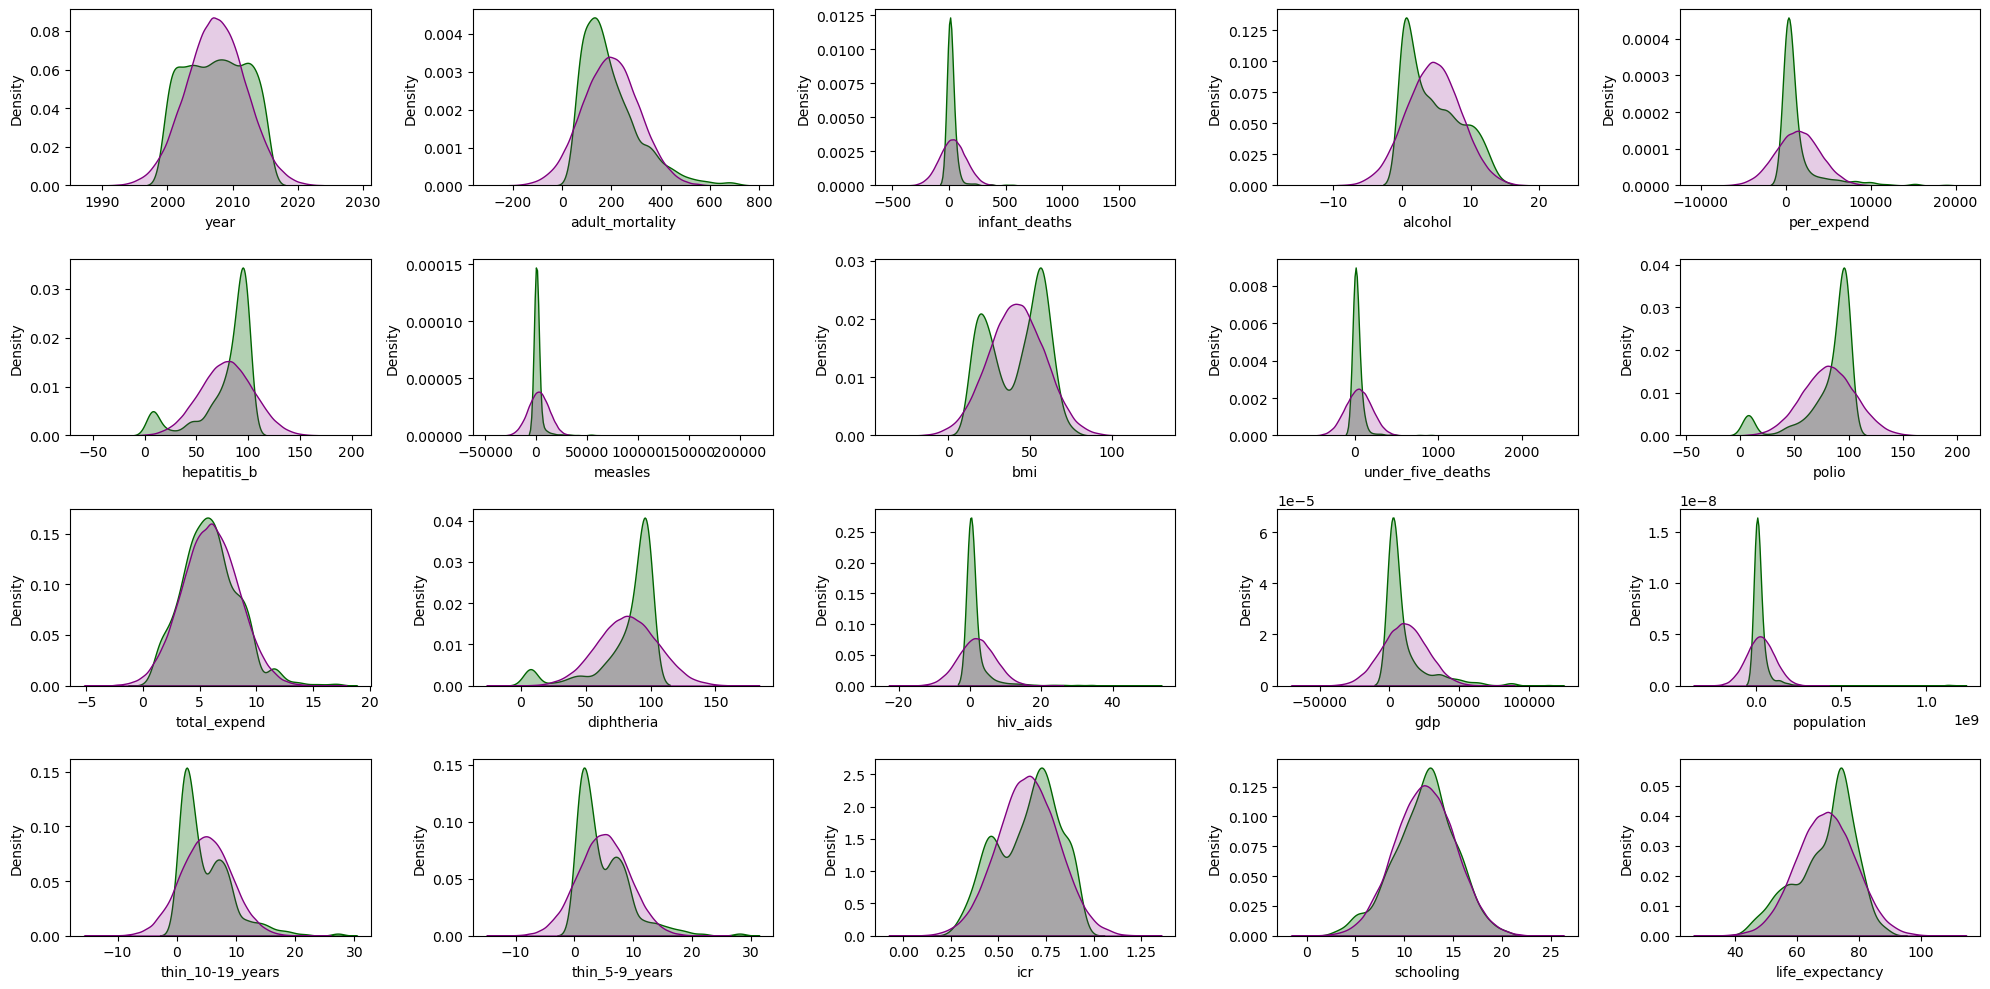

In [9]:
train_df = X_train.drop(columns=['country', 'status_developing'])
train_df['life_expectancy'] = np.array(y_train)
train_df = train_df.where(train_df > 0, np.nan)
display_feature_distributions(train_df)

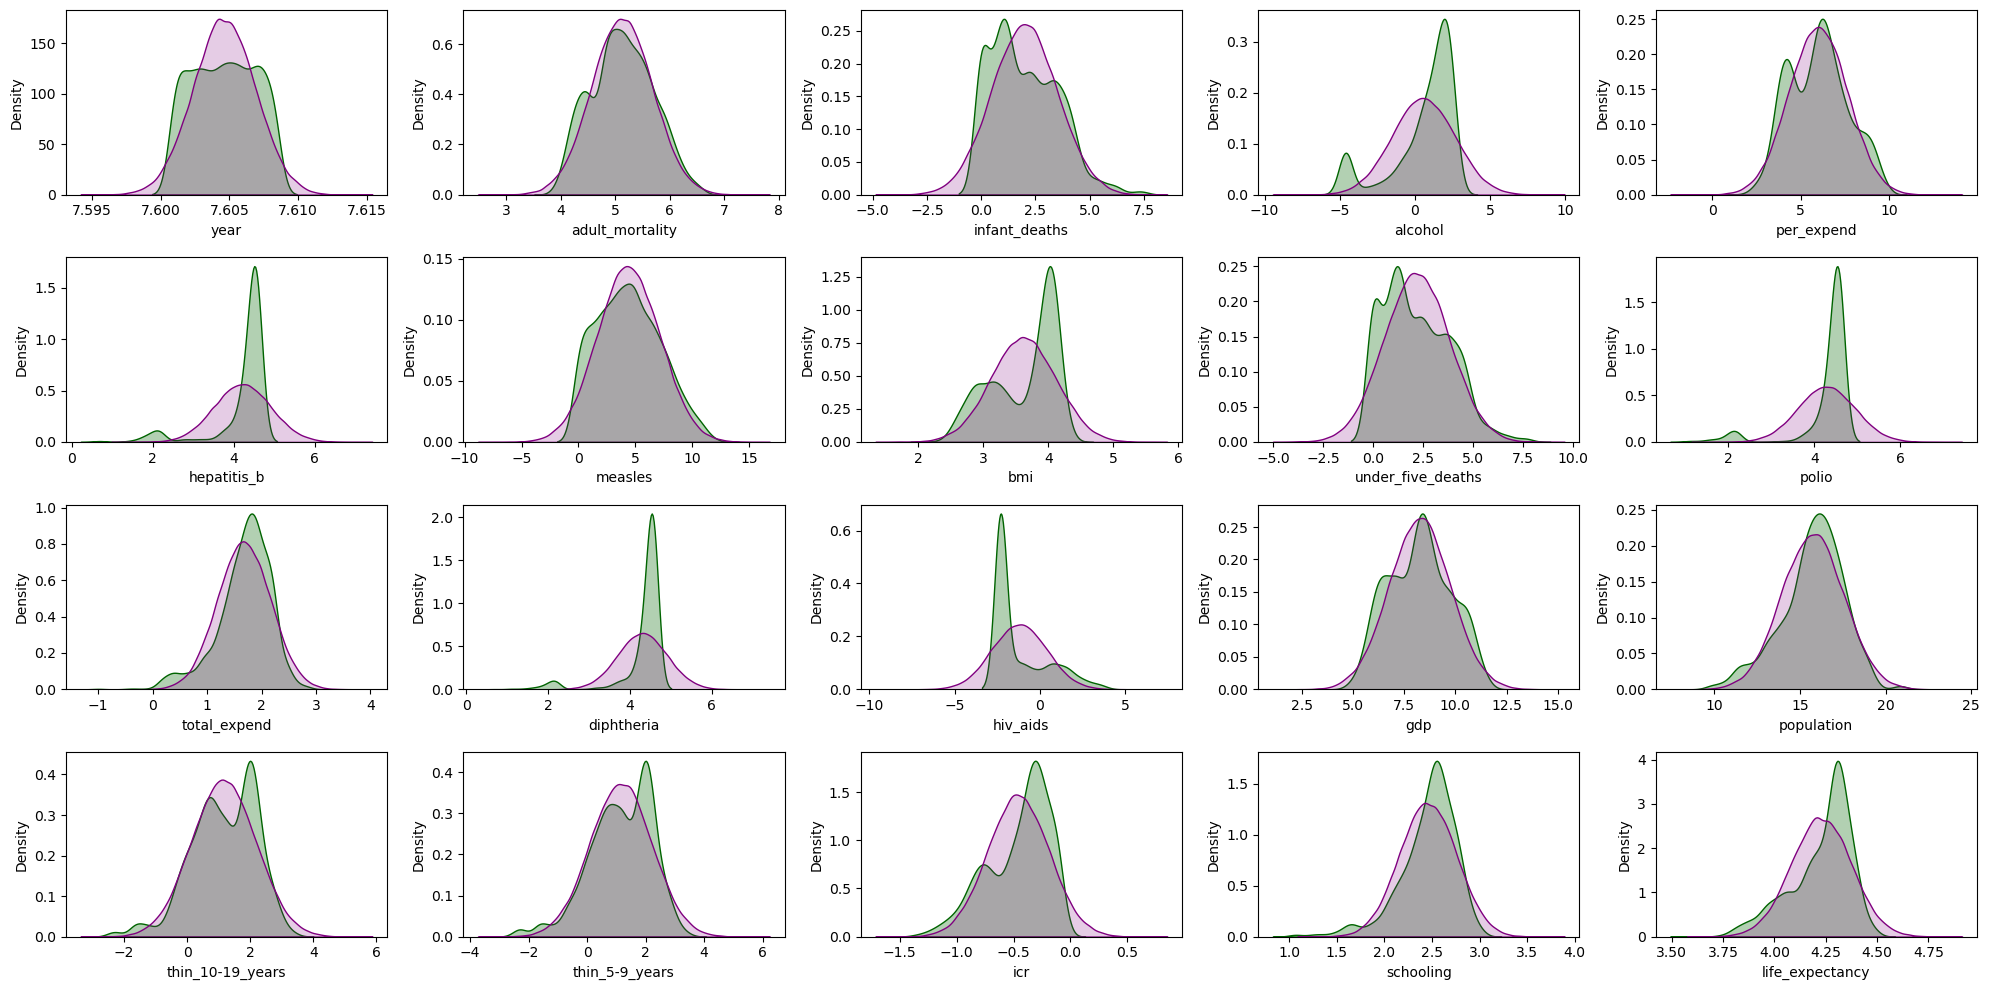

In [10]:
log_df = np.log(train_df.where(train_df > 0, np.nan))
display_feature_distributions(log_df)

In [11]:
def log_transform(column_names, df):
    df[column_names] = np.log(df[column_names])
    return df

X_train = log_transform(['adult_mortality', 'infant_deaths', 'per_expend', 'measles', 'under_five_deaths', 'gdp', 'population', 'thin_10-19_years', 'thin_5-9_years'], X_train)
X_test = log_transform(['adult_mortality', 'infant_deaths', 'per_expend', 'measles', 'under_five_deaths', 'gdp', 'population', 'thin_10-19_years', 'thin_5-9_years'], X_test)

In [12]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
agg_df = X_train.drop(columns=['country', 'population']).agg(['var', lambda x: x.corr(y_train['life_expectancy'])]).T
agg_df.columns = ['var', 'cor']
agg_df = agg_df.sort_values(by=['cor'], key=lambda x: x.abs(), ascending=False)
agg_df

,var,cor
adult_mortality,0.319,-0.928
icr,0.026,0.888
schooling,10.684,0.772
gdp,2.291,0.764
per_expend,2.729,0.754
bmi,304.557,0.707
under_five_deaths,2.724,-0.578
hiv_aids,26.457,-0.557
thin_5-9_years,1.127,-0.539
infant_deaths,2.369,-0.536


## **Model Performance**

After evaluating the features and finding the top regressors for the model I created the 'model_performance' function which is the core function of the regression model that will perform all of the important tasks relating to model implementation and performance. The function takes the training and testing data we have from earlier as its parameters. Then we will perform a k-fold cross validation with 5 splits on the training data to get a reliable gauge of how our model is performing before implemetation on the testing data. The cross validation is also a reliable reference point to check for possible overfitting after evaluating the model on the test data. The main component of the cross validation is the for loop that will train the linear model on the subtraining data and evaluate the model performance on the subtesting and subtraining data using the root mean squared error and the r<sup>2</sup> score. It will perform these evaluations on all permutations of the subtraining and subtesting groups and append them to the respective lists and take the average to get the overall performance for the cross validation. Then the function will perform its main task of training the linear regression model with all the training data and evaluate its performance on the unseen testing data using the same metrics as before. Finally, the function will produce a plot showing the distribution of the residuals against their ideal normal distribution so that we can visually see if the residuals are aprroximately normal, which indicates good performance of the model. 

In [13]:
def model_performance(X_train, X_test, y_train, y_test):
    cv = RepeatedKFold(n_splits=5, random_state=12345, n_repeats=100)
    splitting = cv.split(X=X_train, y=y_train)
    
    RMSEs = []
    train_r2_scores = []
    test_r2_scores = []
    
    for train_index, test_index in splitting:
        
        X_subtraining = X_train.iloc[train_index, :]
        X_subtesting = X_train.iloc[test_index, :]
        y_subtraining = y_train.iloc[train_index, :]
        y_subtesting = y_train.iloc[test_index, :]
        
        scaler = StandardScaler()
        scaler.fit(X_subtraining)
        X_subtraining = scaler.transform(X_subtraining)
        
        X_subtesting = scaler.transform(X_subtesting)
        
        lm_model = LinearRegression()
        lm_model.fit(X=X_subtraining, y=y_train.iloc[train_index, :])
        y_pred = lm_model.predict(X_subtesting)
        
        train_r2_score = lm_model.score(X=X_subtraining, y=y_subtraining)
        test_r2_score = lm_model.score(X=X_subtesting, y=y_subtesting)
        RMSE = mean_squared_error(y_true=y_subtesting, y_pred=y_pred, squared=False)
    
        RMSEs.append(RMSE)
        train_r2_scores.append(train_r2_score)
        test_r2_scores.append(test_r2_score)

    print("K-Fold Cross Validation Performance:")
    print(f"train_R^2: {np.mean(train_r2_scores)}\ntest_R^2: {np.mean(test_r2_scores)}\nRMSE: {np.mean(RMSEs)}\n")
    
    lm_model = LinearRegression()
    lm_model.fit(X_train, y_train)
    
    y_pred = lm_model.predict(X_test)
    
    residuals = (np.array(y_test) - y_pred)[:, 0]
    RMSE = residuals.std()
    R2_square = lm_model.score(X_test, y_test) 
    print("Test Dataset Performance:")
    print(f"RMSE: {RMSE}\nR^2: {R2_square}\n")

    plt.rcParams["figure.figsize"] = [7, 2]
    plt.rcParams["figure.autolayout"] = True
    sns.kdeplot(x=residuals, fill=True, alpha=0.2);
    sns.histplot(x=residuals, fill=True, alpha=0.2, stat='density', bins=20);
    sns.kdeplot(x=np.random.normal(scale=RMSE, size=100000), fill=True, alpha=0.2, color='purple');

## **Optimized Multilinear Regression Model**

The first model I will implement is a simple multilinear regression model using the top features I discovered while doing the feature engineering and analysis from earlier. So, I decide to use 5 of the top regressors that are both highly correlated with the target and also have approximately normal density distributions along with a fair amount of variance. However, of these three criteria I put the least emphasis on the variance because the features have different scaling and some have been log transformed while others have not which means that the variance is not clear for comparison across different features. That being said, I still want to ensure that the features I choose have a fair amount of variance so that the r<sup>2</sup> score is reliable and not calculating the amount of variance my model captures based on features that have small variances. So, I decide to use 'adult_mortality', 'icr', 'gdp', 'per_expend', and 'schooling' as my initial 5 regressors for the model. The model performs well when using these five regressors with an r<sup>2</sup> score of about 0.914 and RMSE of about 2.83 as seen below. This means that the model is already capturing most of the variance in the data when making predictions and is usually within a couple years of the true life expectancy. Furthermore, we can see that our performance on the test dataset is consistent with our k-fold cross validation performance meaning that we are doing a good job of avoiding overfitting. However, I also want to attempt to improve performance in any way without adding unnecessary complexity and risk of overfitting. So I will do some trial and error and play with some other top features that have good variance and correlation with the target along with desireable distributions. After doing this, I found something quite interesting. When I replace 'schooling' with 'hiv_aids' as the fifth regressor, it actually improved the r<sup>2</sup> score to almost 0.926 and also decreased the RMSE to 2.57 on the test data. Further, the performance for the cross validation was also improved in every way. I was not expecting to see this because 'schooling' has a much better correlation and is significantly more normally distributed then 'hiv_aids'. The only possible advantage that 'hiv_aids' has is that there may br more variance but even this is debatable because these two features are measured completely differently. I could not think of an apparent reason as to why 'hiv_aids' should be a better regressor then 'schooling' but clearly it leads to fairly better model performance as seen below. The only explanation I could give is that 'hiv_aids' simply fits better in combination with the other regressors. 

K-Fold Cross Validation Performance:
train_R^2: 0.9124438623777984
test_R^2: 0.9112436744841679
RMSE: 2.8368267092723545

Test Dataset Performance:
RMSE: 2.770385215050218
R^2: 0.9143980547503547



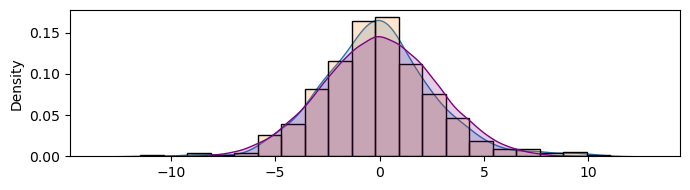

In [14]:
X_train_features = X_train.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'schooling']]
X_test_features = X_test.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'schooling']]
model_performance(X_train_features, X_test_features, y_train, y_test)

K-Fold Cross Validation Performance:
train_R^2: 0.9212975085338075
test_R^2: 0.9202481577402691
RMSE: 2.6886520100132247

Test Dataset Performance:
RMSE: 2.571149533592846
R^2: 0.9262514696678535



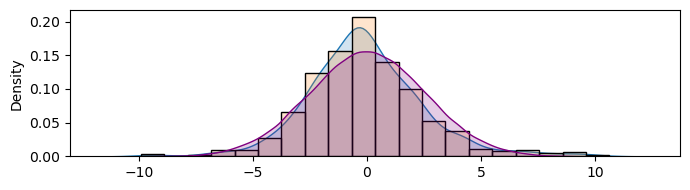

In [15]:
X_train_features = X_train.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'hiv_aids']]
X_test_features = X_test.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'hiv_aids']]
model_performance(X_train_features, X_test_features, y_train, y_test)

## **Optimized Multilinear Regression with PCA**

Next I want to evaluate the performance of a multilinear regresssion combined with PCA to hopefully further improve on the performance of the previous model. So, I first create a new function called 'pca_model_performance' which is very similar to the original 'model_performance' function, however it encorporates the PCA algorithm into both the k-fold cross validation and the implementation on the testing data. Just as I have done with all the other machine learning algorithms used so far, I made sure to scale the data and transform the data based on a PCA model that is fit exclusively to the training data. Similar to before, I will use the same metrics to evaluate the performance of this new regression model combined with PCA. Because PCA creates non-correlated features we do not need to worry about feature selection. So, I pass the training and testing data into the function and decided to test how this new model will perform when using only 10 possible principle components, the model performed well but did not improve on the original multilinear regression, so I then decided to use all possible 19 principle components to hopefully improve on the metrics we had from before. As we can see below, the model is performing very well and improves slightly on the original multilinear regression with an r<sup>2</sup> score of over 0.93 which means that this model is capturing most of the variance of the principle components when making the life expectancy predictions. Furthermore, the RMSE went all the way down to about 2.5 meaning that our life expectancy predictions are a bit more precise with the PCA. Overall, we can clearly see that implementation of PCA leads to slight improvements in performance. 

In [16]:
def pca_model_performance(X_train, X_test, y_train, y_test, n_pc=10):
    
    cv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=12345)
    splitting = cv.split(X=X_train, y=y_train)

    kf_RMSEs = []
    kf_R2_scores = []
    
    for train_index, test_index in splitting:

        X_subtrain = X_train.iloc[train_index, :].copy()
        X_subtest = X_train.iloc[test_index, :].copy()
        y_subtrain = y_train.iloc[train_index, :].copy()
        y_subtest = y_train.iloc[test_index, :].copy()

        scaler_model = StandardScaler(with_std=True).fit(X_subtrain) 
        X_subtrain = scaler_model.transform(X_subtrain) 

        pca_model = PCA(n_components=n_pc)
        pca_model.fit(X_subtrain) 
        X_subtrain = pca_model.transform(X_subtrain) 

        lm_model = LinearRegression()
        lm_model.fit(X=X_subtrain, y=y_subtrain)

        X_subtest = scaler_model.transform(X_subtest) 
        X_subtest = pca_model.transform(X_subtest) 

        kf_R2_score = lm_model.score(X=X_subtest, y=y_subtest)
        y_pred = lm_model.predict(X=X_subtest)
        kf_RMSE = mean_squared_error(y_true=y_subtest, y_pred=y_pred, squared=False)

        kf_R2_scores.append(kf_R2_score)
        kf_RMSEs.append(kf_RMSE)

    print(f"k-fold R^2: {np.mean(kf_R2_scores)}\nk-fold RMSE: {np.mean(kf_RMSEs)}")
    
    scaler = StandardScaler().fit(X_train) 
    X_train = scaler.transform(X_train) 

    pca = PCA(n_components=n_pc)
    pca.fit(X_train) 
    X_train = pca.transform(X_train) 

    lm_model = LinearRegression()
    lm_model.fit(X=X_train, y=y_train)

    X_test = scaler.transform(X_test) 
    X_test = pca.transform(X_test) 

    test_R2_score = lm_model.score(X=X_test, y=y_test)
    y_pred = lm_model.predict(X=X_test)
    test_RMSE = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)

    print(f"Test R^2: {test_R2_score}\nTest RMSE: {test_RMSE}\n")

    residuals = (y_test - y_pred).iloc[:, 0]

    plt.rcParams["figure.figsize"] = [7, 2]
    plt.rcParams["figure.autolayout"] = True
    sns.histplot(x=residuals, fill=True, alpha=0.2, stat='density');
    sns.kdeplot(data=residuals, fill=True, alpha=0.2, legend=False);
    sns.kdeplot(x=np.random.normal(scale=test_RMSE, size=100000), fill=True, alpha=0.2, color='purple');

k-fold R^2: 0.9238721852808165
k-fold RMSE: 2.6266510343771197
Test R^2: 0.9304549339356013
Test RMSE: 2.4985138908688094



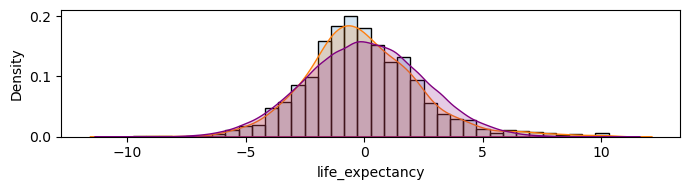

In [17]:
X_train_pca = X_train.drop(columns= ['country', 'status_developing'])
X_test_pca = X_test.drop(columns= ['country', 'status_developing'])
pca_model_performance(X_train_pca, X_test_pca, y_train, y_test, n_pc=19)

## **Custom Regression Model to Address Data Imbalance**

The final model I wanted to evaluate was a custom regression I designed to attempt to improve performance and deal with the imbalance in development status in the dataset. So, I will use a statified sampling method where I split my training and testing data into two groups based on country development status and then take a random sample only from the developing group so that I can preserve as much of the developed country data as possible while creating balanced training and testing data. This is not a straightforward process as I first have to know the exact amount of data contained in each group with respect to both the training and testing data so that I can have truly balanced regressors. I also need to ensure that the 'y_train' and 'y_test' target vectors also match the newly balanced features. So, I created the 'get_balanced_data' function that first joins the target vectors to the feature datasets and split these dataframes into the development groups. Then I will take a simple random sample from the developing groups of both the training and testing data with sample sizes that match the exact amount of developed country data there is in the training and testing data. Obviously, these sample sizes would change depending on the proportions chosen for the initial train-test split. Then I will concatenate the developed country data with the developing data samples to get balanced training and testing datasets. Then I resplit these datasets to get the appropriate target vectors that match the balanced features. The function then returns the balanced training and testing data, and to check that everything is working as intended I will perform a query to ensure that the data is indeed balanced as seen below. I then plugged the balanced data into the original 'model_performance' function to evaluate the performance of my balanced regression model. As we can see, the performance of the balanced model when taking a sample with random seed '3456' actually shows slight improvements in performance across the board, even when compared to PCA which I was not expecting. Thus, this seems to be a fairly effective method for improving model performance and addressing the issue of imbalance in our dataset. However, it is worth noting that the performance of this model will depend on the random sample that we take from the developing country group. To test this I played around with some other random samples and indeed there are cases where the balanced model performs slightly worse then the original regression. Furthermore, it is also possible that there is a random sample that would further improve on this initial sample of seed '3456'. Perhaps a more rigorous way to evaluate the overall performance of this model would be to take a multitude of different samples and take the mean of all the performance metrics after rerunning the experiment many times. However, this is very computationally expensive due to all of the cross validations that would need to be performed along with the cost of retraining and getting new performance scores for a large number of regression models. So, I opted not to go about evaluating performance in this way. 

In [18]:
def get_balanced_data(X_train, X_test, y_train, y_test, seed=3456):
    
    train_data = X_train.copy()
    train_data['life_expectancy'] = y_train
    train_data_developed = train_data.loc[train_data.status_developing == 0, :]
    train_data_developing = train_data.loc[train_data.status_developing == 1, :]
    
    
    test_data = X_test.copy()
    test_data['life_expectancy'] = y_test
    test_data_developed = test_data.loc[test_data.status_developing == 0, :]
    test_data_developing = test_data.loc[test_data.status_developing == 1, :]
    
    train_developing_sample = train_data_developing.sample(n=320, random_state=seed)
    train_data_balanced = pd.concat([train_developing_sample, train_data_developed])
    
    test_developing_sample = test_data_developing.sample(n=208, random_state=seed)
    test_data_balanced = pd.concat([test_developing_sample, test_data_developed])
    
    X_train_balanced = train_data_balanced.loc[:, train_data_balanced.columns != 'life_expectancy']
    y_train_balanced = pd.DataFrame(train_data_balanced.loc[:, 'life_expectancy'])
    X_test_balanced = test_data_balanced.loc[:, test_data_balanced.columns != 'life_expectancy']
    y_test_balanced = pd.DataFrame(test_data_balanced.loc[:, 'life_expectancy'])

    return X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced

In [20]:
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = get_balanced_data(X_train, X_test, y_train, y_test)

In [22]:
X_train_balanced.groupby('status_developing').size()

status_developing
0.000    320
1.000    320
dtype: int64

K-Fold Cross Validation Performance:
train_R^2: 0.9332138289398252
test_R^2: 0.930398439224693
RMSE: 2.515921712070267

Test Dataset Performance:
RMSE: 2.42529141801314
R^2: 0.9323892260019596



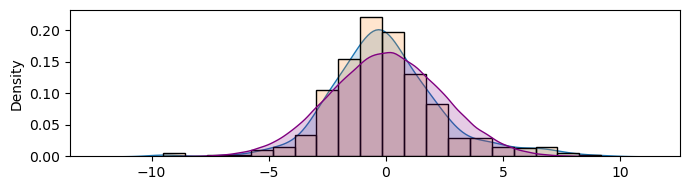

In [23]:
X_train_balanced_features = X_train_balanced.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'hiv_aids']]
X_test_balanced_features = X_test_balanced.loc[:, ['adult_mortality', 'icr', 'gdp', 'per_expend', 'hiv_aids']]
model_performance(X_train_balanced_features, X_test_balanced_features, y_train_balanced, y_test_balanced)